# Astro 133 "Galaxies II"
## Distributions of galaxy properties

Author: Christine Simpson

### Preliminaries: set up plotting parameters

In [10]:
import numpy as np

# setup notebook for inline figures
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import sys
sys.path.append('./code/')

def plot_pretty(dpi=175,fontsize=9):
    # import pyplot and set some parameters to make plots prettier
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)
    plt.rc("figure", dpi=dpi)
    plt.rc('text', usetex=True)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1])

    return

def plot_2d_dist(x,y, xlim,ylim, nxbins,nybins, cmin=1.e-4, cmax=1.0, log=False, weights=None, xlabel='x',ylabel='y', clevs=None, smooth=None, fig_setup=None, savefig=None):
    """
    log = specifies whether logged quantities are passed to be plotted on log-scale outside this routine
    """
    from matplotlib.colors import LogNorm
    import scipy.optimize as opt
    
    def conf_interval(x, pdf, conf_level):
        return np.sum(pdf[pdf > x])-conf_level
    
    if fig_setup is None:
        fig, ax = plt.subplots(figsize=(2.5, 2.5))
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    else:
        ax = fig_setup
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim); ax.set_ylim(ylim)

    if xlim[1] < 0.: ax.invert_xaxis()

    if weights is None: weights = np.ones_like(x)
    H, xbins, ybins = np.histogram2d(x, y, weights=weights, bins=(np.linspace(xlim[0], xlim[1], nxbins),np.linspace(ylim[0], ylim[1], nybins)))
    
    H = np.rot90(H); H = np.flipud(H); 
             
    #X,Y = np.meshgrid(xbins,ybins) 
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 
    if smooth is not None:
        if ( np.size(smooth) < 2):
            raise Exception("smooth needs to be an array of size 2 containing 0=SG window size, 1=SG poly order");
        H = sgolay2d( H, window_size=smooth[0], order=smooth[1])

    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)
    
    if log:
        X = np.power(10.,X); Y = np.power(10.,Y)

    pcol = ax.pcolormesh(X, Y,(Hmask), vmin=cmin*np.max(Hmask), vmax=cmax*np.max(Hmask), cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
    pcol.set_edgecolor('face')

    if clevs is not None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
        
        ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls), 
                norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])
    if savefig:
        plt.savefig(savefig,bbox_inches='tight')
    if fig_setup is None:
        plt.show()
    return


#from plot_utils import plot_pretty
plot_pretty()

# allow automatic reload of imported codes, if they are modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Let's read the fits table with SDSS spectroscopic galaxy sample
This code reads a table of galaxy properties taken from the SDSS survey.  It contains the positions of galaxies, their magnitudes in different filter bands, their redshifts taken from their SDSS spectra and other properties.

In [ ]:
from read_sdss_fits import read_sdss_fits
# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits('/project2/astr13300/Week8/'+'SDSSspecgalsDR8full.fit')

### First we will make some selection cuts

We will select galaxies by their distance (or redshift denoted by the variable **z**) and by their brightness or apparent magnitude.

We will exclude galaxies that are very far away to avoid misclassified systems that look like very distant galaxies.  We therefore exclude systems above a redshift of 1 (the light travel time from a redshift 1 galaxy is half the age of the universe!).

**Question:** We will also exclude nearby galaxies (galaxies with z < 0.005).  This corresponds to roughly the distance of the Virgo cluster (16 Mpc).  Why do you think it is necessary to exclude very nearby galaxies?

**Magnitudes** are a system of quantifying the brightness of objects on a logarithmic scale (i.e. magnitude ~ log(luminosity)).  By convention, smaller values are brighter objects.  We can define magnitudes for different color ranges that we call 'bands' (i.e. r band, g band, b band, etc.).

We are viewing these external galaxies from within our own Milky Way galaxy.  Before we can use the measured magnitudes, we need to correct for **extinction** from dust within the Milky Way.  Dust will absorb and scatter optical light and make external objects look dimmer than they really are.

**Question:** What is the morphology (shape) of the Milky Way?  How will that morphology affect our view of external galaxies?

**Color** is defined as the difference between magntudes in two different magnitude bands (this is the equivalent to the ratio of the luminosities in those bands).  Here we compute a g - r color.

**Question:** Last week you learned about the colors of stellar populations.  The optical light we see from galaxies comes mostly from stars.  What does the color of a galaxy tell you about star formation within the galaxy?

In [5]:
# Redshift cuts
z_min = 0.005; z_max = 1.0

# magnitude cuts appropriate for the SDSS main spectroscopic sample 
m_min = 12.0; m_max = 17.77

# correct r-band Petrosian magnitudes for Galactic extinction before applying magnitude cuts
mr = data['petroMag_r'] - data['extinction_r']
cmr = data['cmodelMag_r'] - data['extinction_r']
cmg = data['cmodelMag_g'] - data['extinction_g']
gr = cmg - cmr

# apply redshift, magnitude, and color cuts
data = data[(data['z'] > z_min) & (data['z'] < z_max) & (mr > m_min) & (mr < m_max) & (gr>-2.5) & (gr<2.5)]
#gr = gr[(data['z'] > z_min) & (data['z'] < z_max) & (mr > m_min) & (mr < m_max) & (gr>-2.5) & (gr<2.5)]

print("selected %d galaxies"%np.shape(data['z']))


selected 650045 galaxies


### Compute absolute magnitudes for SDSS galaxies

We have observed brightnesses for galaxies, but in order to understand physics within the galaxies, we need to know intrinsic luminosities.  In the language of magnitudes, we need to convert the apparent magnitudes to absolute magnitudes.  To do that we need to know the distance to the galaxies.  We compute this from their redshift and cosmological parameters (which you will cover next week, don't worry too much about that).

In [6]:
# now compute luminosity and angular diameter distances for galaxies in the sample
from cosmology import d_l
# define suitable cosmological parameters
# mean matter and vacuum energy densities in units of the critical density 
Om0 = 0.3; OmL = 0.7
h = 0.7 # H0/100
d_H = 2997.92 # c/(100 km/s/Mpc) 

z = data['z']

d_L = d_l(z, Om0, OmL, ninter=20)
d_A = d_L / (1.+z)**2

# dimensionless distance -> Mpc 
d_L *= d_H / h; d_A *= d_H /h 

# Petrosian and cmodel magnitudes in the r band, extinction corrected. 
mpetro = data['petroMag_r'] - data['extinction_r']
mcmodel = data['cmodelMag_r'] - data['extinction_r']

# cmodel and Petrosian absolute magnitudes in the r-band
Mcmodel = mcmodel - 5.0*np.log10(d_L/1e-5)
Mpetro = mpetro - 5.0*np.log10(d_L/1e-5)

gr = data['cmodelMag_g'] - data['extinction_g'] - data['cmodelMag_r'] + data['extinction_r']

### Compute and plot properties of galaxies

Here we will make a few plots:
* A color magnitude diagram for galaxies (absolute magnitude vs. color)
* Color vs. light concentration.  Here we estimate the light concentration by computing the radii containing 50% and 90% of the galaxy's light.  We define the concentration as the ratio of these two scales.
* The central surface brightness.  Surface brightness is a luminosity or magnitude per area.  It is another measure of the diffuseness/concentration of light.
    

In [7]:
#from plot_utils import plot_2d_dist

# select a sample of nearby SDSS galaxies down to a given distance and absolute magnitude
Mlim = -17.0; Dmax = 300.
iloc = (Mcmodel < Mlim) & (d_A < Dmax)

# define data file for the local sample
locdata = data[iloc];

# copy properties in easier to use and descriptively named vectors
#vmaxiloc = vmaxi[iloc]

# redshift and cmodel absolute magnitude
zl = locdata['z']; M_rl  = Mcmodel[iloc]
# g-r color
grl = gr[iloc]

# half-light Petrosian radius, and radius containing 90% of Petrosian magnitude in arcsec
r50l = locdata['petroR50_r']; r90l = locdata['petroR90_r']; 
# light concentration
crl = r90l / r50l 
# mean surface brightness within r50 in mag per square arcsec
mul = locdata['petroMag_r'] - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50l)**2)

/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


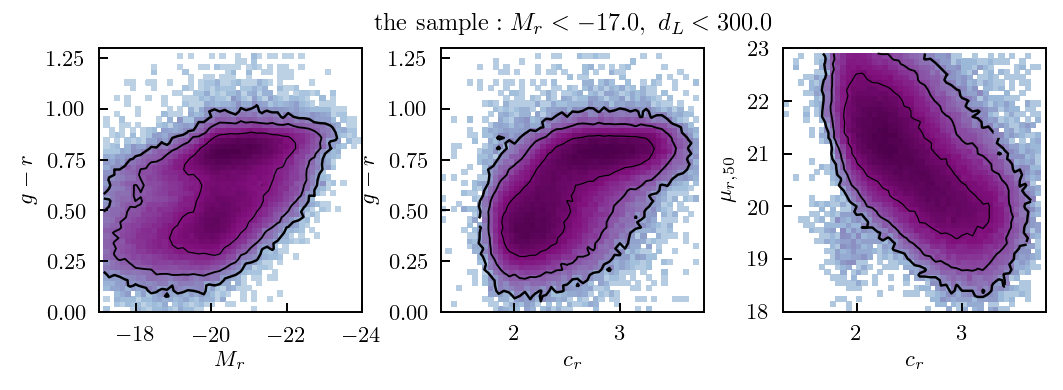

In [8]:
# plot 2D distributions abs. magnitude, color, concentration, and surface brightness within r50
# without Malmquist bias correction
from matplotlib.colors import LogNorm

Mlim = -17.0; Dmax = 300.
Mrlim = [-24.,Mlim]; grlim = [0.,1.3];
crlim = [1.3,3.8]; sblim = [18., 23.]

clevs = [0.68, 0.95, 0.99]

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

ax[1].set_title(r'$\mathrm{the\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(M_rl, grl, Mrlim, grlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])

plot_2d_dist(crl, grl, crlim, grlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])

plot_2d_dist(crl, mul, crlim, sblim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])

# plt.savefig('fig/colcrmur_nocorr.png',bbox_inches='tight')
plt.show()

### Galaxy Morphology and other properties

**Question:** Look at the diagrams above.  What broad features do you see?  Based on the trends you see, where do you think different galaxy types will lie?  We are going to look at a few example galaxies to test these ideas.

Explore Red Sequence ObjID: 1237659324405973156
Explore Green Valley ObjID: 1237667323250933946
Explore Blue Cloud ObjID: 1237664338792153328


/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


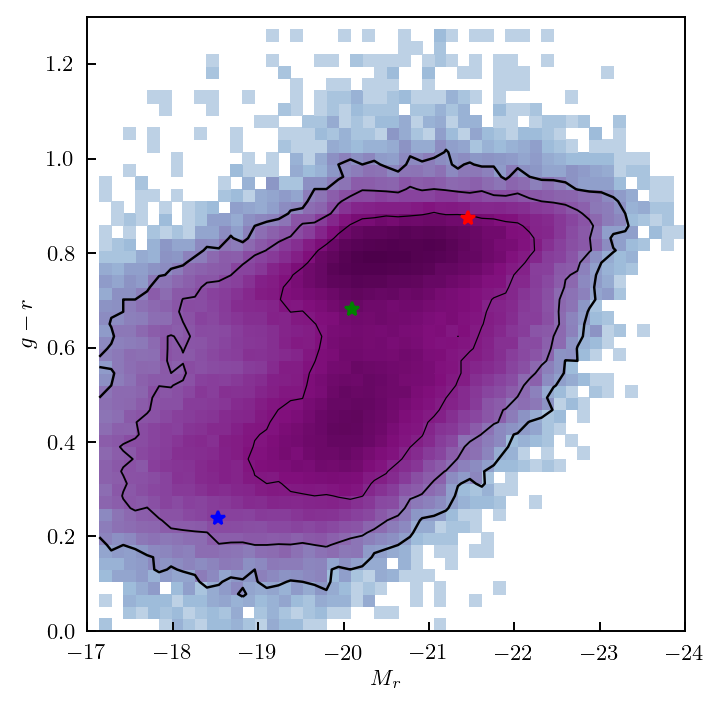

In [9]:
fig, ax = plt.subplots(1,1,figsize=(4., 4.0))
fig.tight_layout()


plot_2d_dist(M_rl, grl, Mrlim, grlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax)

import random
# Choose a random Red Sequence galaxy
irseq, = np.where((grl >0.75) & (grl < 0.9) & (M_rl <-19) & (M_rl > -22))
randint = random.randint(1,len(irseq))
print("Explore Red Sequence ObjID:",locdata['objID'][irseq[randint]])
ax.plot(M_rl[irseq[randint]],grl[irseq[randint]],'r*')

# Choose a random Green Valley galaxy
irseq, = np.where((grl <0.7) & (grl > 0.6))
randint = random.randint(1,len(irseq))
print("Explore Green Valley ObjID:",locdata['objID'][irseq[randint]])
ax.plot(M_rl[irseq[randint]],grl[irseq[randint]],'g*')

# Choose a random Blue Cloud galaxy
irseq, = np.where((grl < 0.5) & (M_rl <-18) & (M_rl > -21.5))
randint = random.randint(1,len(irseq))
print("Explore Blue Cloud ObjID:",locdata['objID'][irseq[randint]])
ax.plot(M_rl[irseq[randint]],grl[irseq[randint]],'b*')


### Exercise:
Open the SDSS Sky Server in a browser:
http://skyserver.sdss.org/dr15/en/tools/explore/Summary.aspx?#

Click 'Search' on the left.

Look up the galaxies selected in the plot with their ObjID.  Iterate a few times (~3 times).  Describe any trends that you see.  Look at the galaxies themselves, but also look around them at their environment.  If you are comfortable with python, try selecting galaxies in parts of the plot that interest you and look at them.

Edwin Hubble concieved of his 'tuning fork' diagram of galaxies as an evolutionary sequence.  He thought elliptical galaxies evolved into spiral galaxies (even today we refer to elliptical & spiral galaxies as 'early' and 'late' type as a historical legacy of this idea).  Given what you've learned about galaxy properties, what do you think about this idea?

Credit to Andrey Kravtsov whose notes and notebooks helped form the basis of this exercise.  Take his class if galaxies interest you!